The S1210 airfoil was designed for high lift coefficients at low Reynolds numbers, which seems to be of interest for vertical axis wind turbine applications [1, 2]. A slotted variant for VAWTs was analyzed in a wind tunnel and using CFD [3], where the data for this notebook came from. The experimental data is not really close to the results below (which predict  higher lift and lower drag) nor is the experimental data close to the CFD results in paper. Which, interestingly, predict lower lift and higher drag. Looks like a fully turbulent simulation though.

Regardless, this is an interesting example to show what virtual displacements are good for. They are used to modify smooth geometries to model kinks or otherwise difficult geometries.

In addition, this notebook shows how to interactively plot and show the changes in the solution during the Newton iterations. Tis takes a toll on the runtime, though.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
interactive_plot = True
    
import numpy as np
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import logging
logging.getLogger().setLevel(logging.ERROR)

<IPython.core.display.Javascript object>


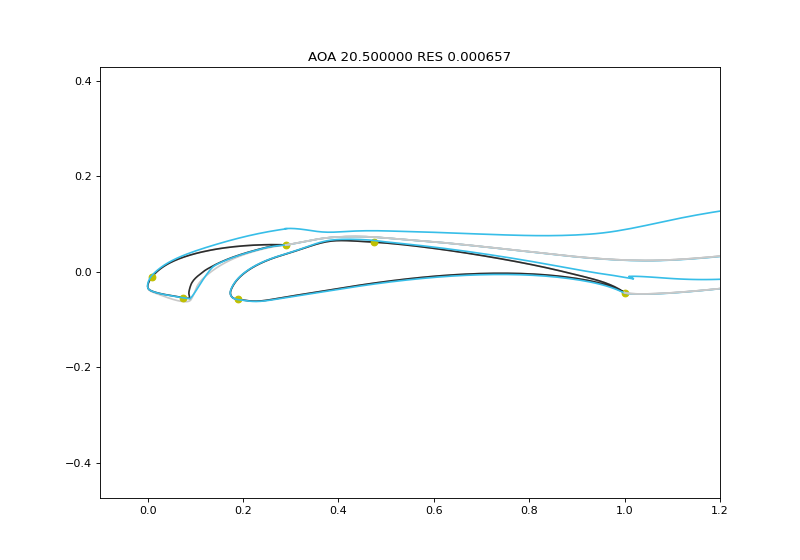

In [2]:
if interactive_plot:
    %matplotlib notebook
    matplotlib.rcParams['figure.figsize'] = [10, 7] 
    lines = None
    fig, ax = plt.subplots(1,1)
else:
    %matplotlib inline
    matplotlib.rcParams['figure.figsize'] = [12, 6]
%config InlineBackend.figure_format = 'svg'

In [3]:
BASE = vft.repanel(vft.read_selig("S1210Base.dat"),230)
SLOT = vft.repanel(vft.read_selig("S1210Slot.dat"),200)
SLOT0 = vft.read_selig("S1210Slot0.dat") # Actual slot shape


# Virtual displacement
[vdSlot,SLOTD] = vft.virtual_displacement_from_geometry(SLOT,SLOT0)
vdSlot[0] = 0.0
vdSlot[-1] = 0.0

AOARANGE = np.arange(5,21,0.5)

# Setup
RE = 200000
ncrit = 9
Mach = 0.0
AOA0 = AOARANGE[0]
s = vf.setup(Re=RE,Ma=Mach,Ncrit=ncrit,Alpha=AOA0)
s.IterateWakes = True
s.Itermax = 1
s.Silent = True
s.Tolerance = 1e-3

BASE[1,:]-=.5
SLOT[1,:]-=.5

# Set-up and initialize based on inviscid panel solution
(p,bl,x) = vf.init([BASE,SLOT],s)

xn = x.copy()
alv = []
clv = []
cdv = []

for alpha in AOARANGE:
    s.Alpha = alpha
    res = None
    grad = None
    for k in range(int(100/s.Itermax)): # Make effectively 100 iterations, but show some in between
        [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad,[None,vdSlot])
        # Plot geometry
        if interactive_plot:
            lines = vfp.plot_geometry(ax,p,bl,lines)
        nres=np.sqrt(np.dot(res.T,res))
        title = "AOA %f RES %f"%(alpha,nres)
        ax.set_title(title)
        
        fig.canvas.draw()
        if flag:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD+bl[1].CD)
            print('AL: %f CL: %f CD: %f' % (alpha,clv[-1],cdv[-1]) ) 
            break


AL: 5.000000 CL: 1.458351 CD: 0.025779
AL: 5.500000 CL: 1.510921 CD: 0.025779
AL: 6.000000 CL: 1.562451 CD: 0.025702
AL: 6.500000 CL: 1.613272 CD: 0.025743
AL: 7.000000 CL: 1.662666 CD: 0.026366
AL: 7.500000 CL: 1.712237 CD: 0.027119
AL: 8.000000 CL: 1.760279 CD: 0.028255
AL: 8.500000 CL: 1.809009 CD: 0.029399
AL: 9.000000 CL: 1.855837 CD: 0.030884
AL: 9.500000 CL: 1.902510 CD: 0.032478
AL: 10.000000 CL: 1.952509 CD: 0.035172
AL: 10.500000 CL: 1.998671 CD: 0.036320
AL: 11.000000 CL: 2.043005 CD: 0.037646
AL: 11.500000 CL: 2.088350 CD: 0.038863
AL: 12.000000 CL: 2.132527 CD: 0.040204
AL: 12.500000 CL: 2.176992 CD: 0.041454
AL: 13.000000 CL: 2.220970 CD: 0.042673
AL: 13.500000 CL: 2.263993 CD: 0.043820
AL: 14.000000 CL: 2.308096 CD: 0.044891
AL: 14.500000 CL: 2.351954 CD: 0.046536
AL: 15.000000 CL: 2.394531 CD: 0.051486
AL: 15.500000 CL: 2.441562 CD: 0.056283
AL: 16.000000 CL: 2.484151 CD: 0.060923
AL: 16.500000 CL: 2.525452 CD: 0.066293
AL: 17.000000 CL: 2.569311 CD: 0.071709
AL: 17.500

<IPython.core.display.Javascript object>


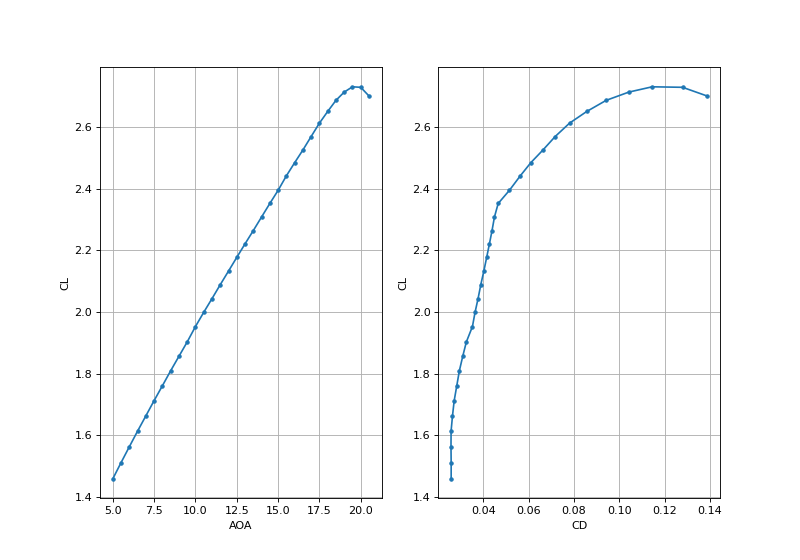

In [4]:
# Make a new plot with the results
fig,ax = plt.subplots(1,2)
ax[0].plot(alv,clv,marker=".")
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].grid(1)
ax[1].plot(cdv,clv,marker=".")
ax[1].set_xlabel('CD')
ax[1].set_ylabel('CL');
ax[1].grid(1)

[1] Islam, Mazharul, et al. *Investigation of low reynolds number airfoils for fixed-pitch straight-bladed VAWT.* 47th AIAA Aerospace Sciences Meeting including The New Horizons Forum and Aerospace Exposition. 2009.

[2] Singh, M. A., A. Biswas, and R. D. Misra. *Investigation of self-starting and high rotor solidity on the performance of a three S1210 blade H-type Darrieus rotor.* Renewable energy 76 (2015): 381-387.

[3] Chougule, Prasad, and Søren RK Nielsen. *Simulation of flow over double-element airfoil and wind tunnel test for use in vertical axis wind turbine.* Journal of Physics: Conference Series. Vol. 524. No. 1. IOP Publishing, 2014.